# Climate Analysis, Hawaii

### Import dependencies

In [1]:
from __future__ import division
%matplotlib inline
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

### Reflect Tables into SQLAlchemy ORM

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2b4e09f3c50>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [9]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2b4e0a38710>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

### Exploratory Climate Analysis

#### Design a query to retrieve the last 12 months of precipitation data and plot the results

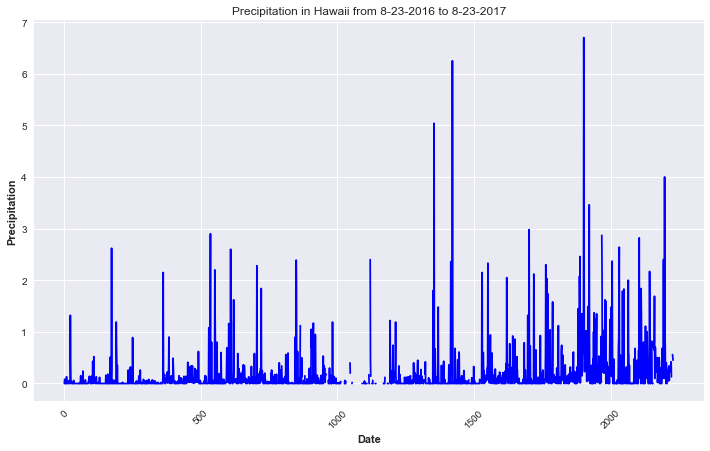

In [11]:
# Calculate the date 1 year ago from the last data point in the database
end_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
end_date = dt.date(2017, 8, 23)
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_analysis_1 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23").\
    filter(Measurement.date <= "2017-08-23").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
pcp_df = pd.DataFrame(precipitation_analysis_1)

# Use Pandas Plotting with Matplotlib to plot the data
pcp_plot = pcp_df.plot(figsize = (12, 7), sort_columns=True, rot=45, use_index=True, legend=False, grid=True, color='b')
plt.ylabel('Precipitation', weight='bold')
plt.xlabel('Date', weight='bold')
plt.title("Precipitation in Hawaii from 8-23-2016 to 8-23-2017")
plt.savefig("./output/Precipitation_12mos.png")
plt.show()

#### Statistical data exploration

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
pcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.id).count()
print("The number of stations is:")
print(station_count)

The number of stations is:
9


In [17]:
# List the stations and the counts in descending order.
busy_stations = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
busy_stations

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [18]:
print("The most active station is:")
print("Waihee")

The most active station is:
Waihee


#### Waihee Station Analysis

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

waihee_values = session.query(Measurement.tobs).\
filter(Measurement.station == "USC00519281", Measurement.date >="2016-08-23", Measurement.date <="2017-08-23").\
all()
waihee_array = np.asarray(waihee_values)
# print(waihee_array)
max_value = max(waihee_array)
min_value = min(waihee_array)
avg_value = sum(waihee_array)/len(waihee_array)

# print(max_value, min_value, avg_value)

waihee_df = pd.DataFrame({
    "Max Temp Recorded": [83],
    "Min Temp Recorded": [59],
    "Avg. Temp": [73.11]
})
print("Waihee station statistics from 8/23/2016 to 8/23/2017:")
waihee_df.head()

Waihee station statistics from 8/23/2016 to 8/23/2017:


,Max Temp Recorded,Min Temp Recorded,Avg. Temp
0,83,59,73.11


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = [temp[0] for temp in waihee_array]

Text(0.5, 16.0, 'Temperature')

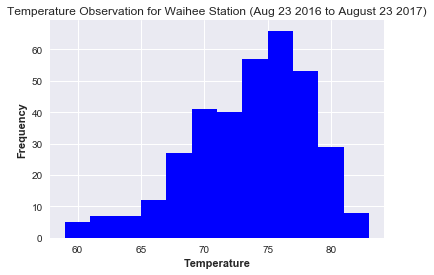

In [22]:
plt.hist(temperatures, bins=12, color='b')
plt.title("Temperature Observation for Waihee Station (Aug 23 2016 to August 23 2017)")
plt.savefig("./output/waihee_histogram.png")
plt.ylabel('Frequency', weight='bold')
plt.xlabel('Temperature', weight='bold')

## Temperature Analysis

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

In [23]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2016-02-28', '2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = calc_temps('2016-08-23', '2017-08-23')
temps

[(58.0, 74.59058295964125, 87.0)]

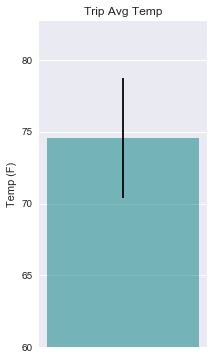

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='teal', alpha=0.5)
plt.title('Trip Avg Temp')
plt.savefig("./output/trip_avg_temp.png")
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()

In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def rainfall(start_date, end_date):
    return session.query(Measurement.station, 
                         Measurement.prcp.label('rainfall'),
                         Station.latitude,
                         Station.longitude,
                         Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date).\
                            order_by('rainfall DESC').all()

rainfall('2016-08-23', '2017-08-23')

[('USC00519281', 1.79, 21.45167, -157.84888999999998, 32.9),
 ('USC00516128', 0.7, 21.3331, -157.8025, 152.4),
 ('USC00513117', 0.15, 21.4234, -157.8015, 14.6),
 ('USC00514830', 0.05, 21.5213, -157.8374, 7.0),
 ('USC00519523', 0.02, 21.33556, -157.71139, 19.5),
 ('USC00519397', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00517948', None, 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
